In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
import pickle
pd.set_option('display.max_columns', 500)
from scipy.ndimage import gaussian_filter1d

In [2]:
datafolder = "D:\\neuromatch2024\\datasets\\project\\Allen\\temp\\combined_files\\"
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=datafolder)

ophys_session_id = 854060305
ophys_experiment_ids = [854759890, 854759894, 854759896, 854759898]

# experiments = {}
# # ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
# for ophys_experiment_id in ophys_experiment_ids:
#     experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(
#         ophys_experiment_id
#     )

with open(f'{datafolder}masterfile_{ophys_session_id}.pickle', 'rb') as handle:
    masterdict = pickle.load(handle)

In [3]:
neural_data = masterdict["neural_data"]
stimulus_table = masterdict["stimulus_table"]
licks = masterdict["licks"]
rewards = masterdict["rewards"]
eyetracking = masterdict["eyetracking"]
running = masterdict["running"]

In [4]:
len(stimulus_table), len(licks)

(13806, 489)

In [5]:
def annotate_licks(ls, rs, st):
    licks = ls.copy()
    rewards = rs.copy()
    stimulus_table = st.copy()

    bout_threshold = 0.7
    stim_start = stimulus_table[stimulus_table.omitted == False]["start_time"].values[0]
    stim_end = stimulus_table["start_time"].values[-1] + 0.75
    licks.query("(timestamps > @stim_start) and (timestamps <= @stim_end)", inplace=True)
    licks.reset_index(drop=True, inplace=True)
    # Computing ILI for each lick
    licks["pre_ili"] = np.concatenate([[np.nan], np.diff(licks.timestamps.values)])
    licks["post_ili"] = np.concatenate([np.diff(licks.timestamps.values), [np.nan]])
    # Segment licking bouts
    licks["bout_start"] = licks["pre_ili"] > bout_threshold
    licks["bout_end"] = licks["post_ili"] > bout_threshold
    licks.loc[licks["pre_ili"].apply(np.isnan), "bout_start"] = True
    licks.loc[licks["post_ili"].apply(np.isnan), "bout_end"] = True
    licks["bout_number"] = np.cumsum(licks["bout_start"])

    # Annotate rewards
    # Iterate through rewards
    licks["rewarded"] = False  # Setting default to False
    licks["num_rewards"] = 0
    for index, row in rewards.iterrows():
        if row["auto_rewarded"]:
            # Assign to nearest lick
            mylick = np.abs(licks.timestamps - row.timestamps).idxmin()
        else:
            # Assign reward to last lick before reward time
            this_reward_lick_times = np.where(licks.timestamps <= row.timestamps)[0]
            if len(this_reward_lick_times) == 0:
                raise Exception("First lick was after first reward")
            else:
                mylick = this_reward_lick_times[-1]
        licks.loc[mylick, "rewarded"] = True
        # licks can be double assigned to rewards because of auto-rewards
        licks.loc[mylick, "num_rewards"] += 1

    ## Annotate bout rewards
    x = (
        licks.groupby("bout_number")
        .any("rewarded")
        .reset_index()
        .rename(columns = {"rewarded": "bout_rewarded"})
    )
    y = (
        licks.groupby("bout_number")["num_rewards"]
        .sum()
        .reset_index()
        .rename(columns = {"num_rewards": "bout_num_rewards"})
    )

    temp = x[["bout_number", "bout_rewarded"]].merge(y, on="bout_number", how="left")
    licks = licks.merge(temp, on="bout_number", how="left")

    ## QC
    ## Check that all rewards are matched to a lick
    num_lick_rewards = licks["rewarded"].sum()
    num_rewards = len(rewards)
    double_rewards = np.sum(licks.query("num_rewards >1")["num_rewards"] - 1)
    assert (
        num_rewards == num_lick_rewards + double_rewards
    ), "Lick Annotations don't match number of rewards"

    # Check that all rewards are matched to a bout
    num_rewarded_bouts = np.sum(licks["bout_rewarded"] & licks["bout_start"])
    double_rewarded_bouts = np.sum(
        licks[
            licks["bout_rewarded"] & licks["bout_start"] & (licks["bout_num_rewards"] > 1)
        ]["bout_num_rewards"]
        - 1
    )
    assert (
        num_rewards == num_rewarded_bouts + double_rewarded_bouts
    ), "Bout Annotations don't match number of rewards"

    # Check that bouts start and stop
    num_bout_start = licks["bout_start"].sum()
    num_bout_end = licks["bout_end"].sum()
    num_bouts = licks["bout_number"].max()
    assert num_bout_start == num_bout_end, "Bout Starts and Bout Ends don't align"
    assert num_bout_start == num_bouts, "Number of bouts is incorrect"

    return licks

licks_annotated = annotate_licks(licks, rewards, stimulus_table)
licks_annotated

,timestamps,frame,pre_ili,post_ili,bout_start,bout_end,bout_number,rewarded,num_rewards,bout_rewarded,bout_num_rewards
0,311.11771,18020,NaN,0.15012,True,False,1,False,0,False,0
1,311.26783,18029,0.15012,2.78557,False,True,1,False,0,False,0
2,314.05340,18196,2.78557,5.27101,True,True,2,False,0,False,0
3,319.32441,18512,5.27101,0.31693,True,False,3,True,1,True,1
4,319.64134,18531,0.31693,0.26688,False,False,3,False,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...
478,2595.66644,154981,194.77570,2.30188,True,True,64,False,0,False,0
479,2597.96832,155119,2.30188,541.64222,True,True,65,False,0,False,0
480,3139.61054,187591,541.64222,460.92636,True,True,66,False,0,False,0
481,3600.53690,215224,460.92636,639.85574,True,True,67,False,0,False,0


In [6]:
def annotate_bouts(ls, st):
    """
    Uses the bout annotations in licks to annotate stimulus_table

    Adds to stimulus_table
        bout_start,     (boolean) Whether a licking bout started during this image
        num_bout_start, (int) The number of licking bouts that started during this
                        image. This can be greater than 1 because the bout duration
                        is less than 750ms.
        bout_number,    (int) The label of the licking bout that started during this
                        image
        bout_end,       (boolean) Whether a licking bout ended during this image
        num_bout_end,   (int) The number of licking bouts that ended during this
                        image.

    """
    licks = ls.copy()
    stimulus_table = st.copy()

    # Annotate Bout Starts
    bout_starts = licks[licks["bout_start"]]
    stimulus_table["bout_start"] = False
    stimulus_table["num_bout_start"] = 0
    for index, x in bout_starts.iterrows():
        filter_start = stimulus_table.query("start_time < @x.timestamps")
        if len(filter_start) > 0:
            # Mark the last stimulus that started before the bout started
            start_index = filter_start.index[-1]
            stimulus_table.loc[start_index, "bout_start"] = True
            stimulus_table.loc[start_index, "num_bout_start"] += 1
            stimulus_table.loc[start_index, "bout_number"] = x.bout_number
        elif x.timestamps <= stimulus_table.iloc[0].start_time:
            # Bout started before stimulus, mark the first stimulus as start
            stimulus_table.loc[0, "bout_start"] = True
            stimulus_table.loc[0, "num_bout_start"] += 1
        else:
            raise Exception(
                "couldnt annotate bout start (bout number: {})".format(index)
            )

    # Annotate Bout Ends
    bout_ends = licks[licks["bout_end"]]
    stimulus_table["bout_end"] = False
    stimulus_table["num_bout_end"] = 0
    for index, x in bout_ends.iterrows():
        filter_end = stimulus_table.query("start_time < @x.timestamps")
        if len(filter_end) > 0:
            # Mark the last stimulus that started before the bout ended
            end_index = filter_end.index[-1]
            stimulus_table.loc[end_index, "bout_end"] = True
            stimulus_table.loc[end_index, "num_bout_end"] += 1
        elif x.timestamps <= stimulus_table.iloc[0].start_time:
            # Bout started before stimulus, mark the first stimulus as start
            stimulus_table.loc[0, "bout_end"] = True
            stimulus_table.loc[0, "num_bout_end"] += 1
        else:
            raise Exception("couldnt annotate bout end (bout number: {})".format(index))

    # Annotate In-Bout
    stimulus_table["in_lick_bout"] = (
        stimulus_table["num_bout_start"].cumsum()
        > stimulus_table["num_bout_end"].cumsum()
    )
    stimulus_table["in_lick_bout"] = stimulus_table["in_lick_bout"].shift(
        fill_value=False
    )
    overlap_index = (
        (stimulus_table["in_lick_bout"])
        & (stimulus_table["bout_start"])
        & (stimulus_table["num_bout_end"] >= 1)
    )
    stimulus_table.loc[overlap_index, "in_lick_bout"] = False

    stimulus_table = stimulus_table.merge(
        licks[["bout_number", "bout_start", "bout_end", "rewarded",	"num_rewards", "bout_rewarded",	"bout_num_rewards"]],
        on = ["bout_number", "bout_start", "bout_end"],
        how = "left"
    )
    

    ##### QC
    num_bouts_sp_start = stimulus_table["num_bout_start"].sum()
    num_bouts_sp_end = stimulus_table["num_bout_end"].sum()
    num_bouts_licks = licks.bout_start.sum()
    
    
    assert (
        num_bouts_sp_start == num_bouts_licks
    ), "Number of bouts doesnt match between licks table and stimulus table"
    assert (
        num_bouts_sp_start == num_bouts_sp_end
    ), "Mismatch between bout starts and bout ends"
    
    
    # assert stimulus_table.query("bout_start")[
    #     "licked"
    # ].all(), "All licking bout start should have licks"
    # assert stimulus_table.query("bout_end")[
    #     "licked"
    # ].all(), "All licking bout ends should have licks"
    # assert np.all(
    #     stimulus_table["in_lick_bout"]
    #     | stimulus_table["bout_start"]
    #     | ~stimulus_table["licked"]
    # ), "must either not have licked, or be in lick bout, or bout start"
    # assert np.all(
    #     ~(stimulus_table["in_lick_bout"] & stimulus_table["bout_start"])
    # ), "Cant be in a bout and a bout_start"

    return stimulus_table

stimulus_table_annotated = annotate_bouts(licks_annotated, stimulus_table)
stimulus_table_annotated


,stimulus_presentations_id,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,stimulus_name,is_sham_change,active,bout_start,num_bout_start,bout_number,bout_end,num_bout_end,in_lick_bout,rewarded,num_rewards,bout_rewarded,bout_num_rewards
0,0,0,initial_gray_screen_5min,-99,NaN,-99,310.569786,0.000000,310.569786,0,17985,False,<NA>,<NA>,-99,0,-99,spontaneous,False,False,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
1,1,1,change_detection_behavior,0,im000,-99,0.250210,310.569786,310.819996,17985,18000,False,False,False,-99,1,0,Natural_Images_Lum_Matched_set_ophys_6_2017,False,True,True,1,1.0,True,1,False,NaN,NaN,NaN,NaN
2,2,1,change_detection_behavior,0,im000,-99,0.250200,311.320396,311.570596,18030,18045,False,False,False,-99,2,0,Natural_Images_Lum_Matched_set_ophys_6_2017,False,True,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
3,3,1,change_detection_behavior,0,im000,-99,0.250170,312.071016,312.321186,18075,18090,False,False,False,-99,3,1,Natural_Images_Lum_Matched_set_ophys_6_2017,False,True,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
4,4,1,change_detection_behavior,0,im000,-99,0.250190,312.821616,313.071806,18120,18135,False,False,False,-99,4,1,Natural_Images_Lum_Matched_set_ophys_6_2017,False,True,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13801,13801,3,natural_movie_one,-99,NaN,895,0.033330,4517.421376,4517.454706,270190,270191,False,<NA>,<NA>,9,9002,-99,natural_movie_one,False,False,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
13802,13802,3,natural_movie_one,-99,NaN,896,0.033390,4517.454706,4517.488096,270192,270193,False,<NA>,<NA>,9,9003,-99,natural_movie_one,False,False,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
13803,13803,3,natural_movie_one,-99,NaN,897,0.033360,4517.488096,4517.521456,270194,270195,False,<NA>,<NA>,9,9004,-99,natural_movie_one,False,False,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN
13804,13804,3,natural_movie_one,-99,NaN,898,0.033320,4517.521456,4517.554776,270196,270197,False,<NA>,<NA>,9,9005,-99,natural_movie_one,False,False,False,0,NaN,False,0,False,NaN,NaN,NaN,NaN


In [26]:
stimulus_table_annotated["num_licks"] = [
    len(x) for x in stimulus_table_annotated["licks"]
]
stimulus_table_annotated["lick_rate"] = (
    stimulus_table_annotated["num_licks"]
    .rolling(win_dur, min_periods=1, win_type=win_type, center=True)
    .mean(std=win_std)
    / 0.75
)

# Get Reward Rate / second
stimulus_table_annotated["rewarded"] = [
    len(this_reward) > 0 for this_reward in stimulus_table_annotated["rewards"]
]
stimulus_table_annotated["reward_rate"] = (
    stimulus_table_annotated["rewarded"]
    .rolling(win_dur, min_periods=1, win_type=win_type, center=True)
    .mean(std=win_std)
    / 0.75
)

# Get Bout Rate / second
stimulus_table_annotated["bout_rate"] = (
    stimulus_table_annotated["bout_start"]
    .rolling(win_dur, min_periods=1, win_type=win_type, center=True)
    .mean(std=win_std)
    / 0.75
)

array([nan, False, True], dtype=object)

## Plotting stimulus changes and sham changes

In [6]:
stimulus_table.image_name.value_counts()

im106      644
im000      599
im054      585
im045      577
im073      571
im031      549
im035      549
im075      545
omitted    185
Name: image_name, dtype: int64

In [7]:
img_to_color = {
    "im106" : "#66c2a5", 
    "im000" : "#fc8d62",
    "im054" : "#8da0cb",
    "im045" : "#e78ac3",
    "im073" : "#a6d854",
    "im031" : "#ffd92f",
    "im035" : "#e5c494",
    "im075" : "#b3b3b3",
}

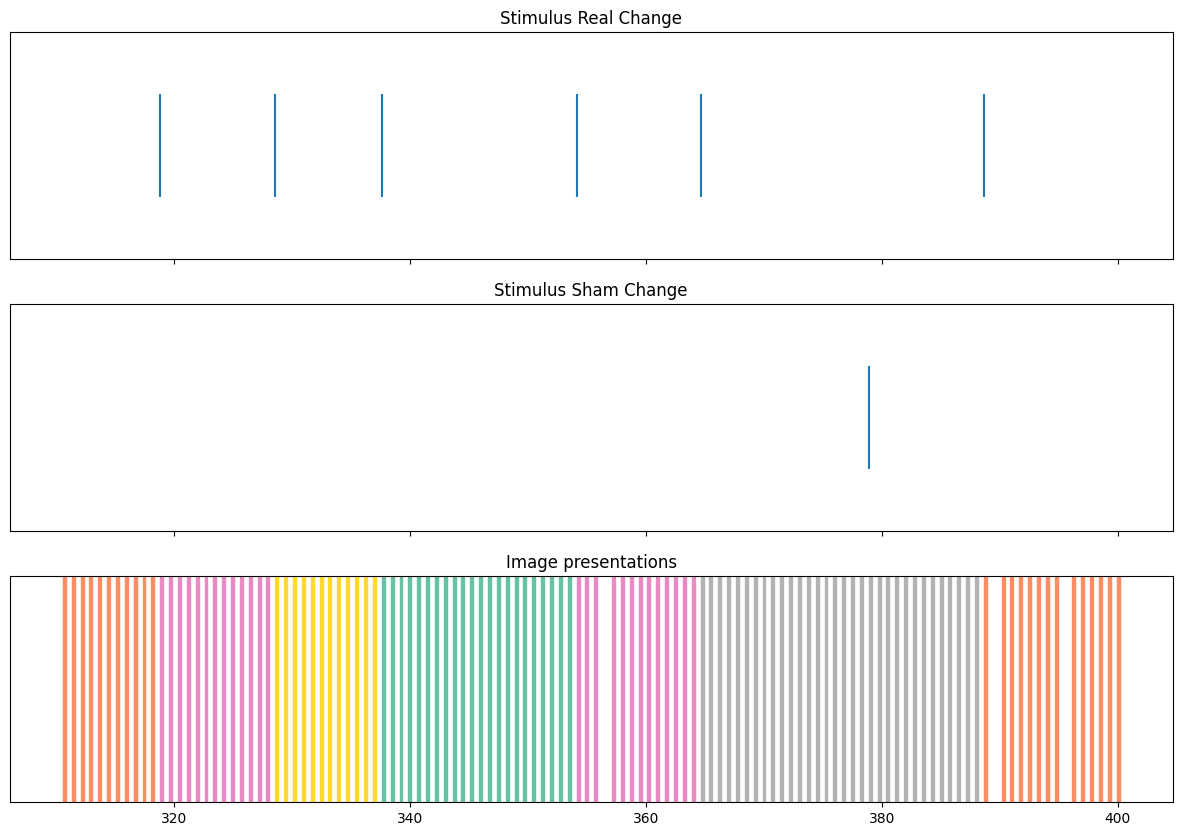

In [8]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=3, sharex=True)

t1 = 300
t2 = 400

ax[0].eventplot(stimulus_table[(stimulus_table.is_change) & (stimulus_table.start_time.between(t1, t2))].start_time)
ax[0].set_title("Stimulus Real Change")

ax[1].eventplot(stimulus_table[(stimulus_table.is_sham_change) & (stimulus_table.start_time.between(t1, t2))].start_time)
ax[1].set_title("Stimulus Sham Change")

for _, stimulus in stimulus_table[(stimulus_table.start_time.between(t1, t2))].iterrows():
    if stimulus["image_name"] == "omitted":
        continue 
    else:
        ax[2].axvspan(stimulus.start_time, stimulus.end_time, color=img_to_color[stimulus["image_name"]])
ax[2].set_title("Image presentations");

for axes in ax:
    axes.set_yticks([])

